Authour: Dana Chermesh, Nov 2018
# Opportunity Zones
This Ipython notebook explores the official published data regarding Opportunity Zones accross the country.

## 0. Imports

In [1]:
import requests
import pandas as pd
import numpy as np

from __future__ import print_function, division
import matplotlib.pylab as pl
import seaborn as sns
sns.set_style('whitegrid')
# import json

# Spatial
import geopandas as gpd
import fiona
import shapely

import statsmodels.formula.api as smf
import statsmodels.api as sm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1. Data aqcuisition and exploration
The shapefiles were downloaded from https://www.cdfifund.gov/Pages/Opportunity-Zones.aspx; for Direct download click [here](https://www.cdfifund.gov/Documents/Opportunity%20Zones2.zip)

In [5]:
# reading in data
oz = gpd.GeoDataFrame.from_file("OZ Tracts/DesignatedOZTracts_6.14.shp")

# oz = oz.set_index('GEOID10')

print(oz.shape)
print(oz.columns)
print(oz.crs) # .crs is the projection of the geometry, important for joining+plotting different geographies
oz.head(2)

(8686, 58)
Index(['ObjectID', 'STATE_FIPS', 'CNTY_FIPS', 'STCOFIPS', 'TRACT', 'FIPS',
       'POP2010', 'POP10_SQMI', 'POP2012', 'POP12_SQMI', 'WHITE', 'BLACK',
       'AMERI_ES', 'ASIAN', 'HAWN_PI', 'HISPANIC', 'OTHER', 'MULT_RACE',
       'MALES', 'FEMALES', 'AGE_UNDER5', 'AGE_5_9', 'AGE_10_14', 'AGE_15_19',
       'AGE_20_24', 'AGE_25_34', 'AGE_35_44', 'AGE_45_54', 'AGE_55_64',
       'AGE_65_74', 'AGE_75_84', 'AGE_85_UP', 'MED_AGE', 'MED_AGE_M',
       'MED_AGE_F', 'HOUSEHOLDS', 'AVE_HH_SZ', 'HSEHLD_1_M', 'HSEHLD_1_F',
       'MARHH_CHD', 'MARHH_NO_C', 'MHH_CHILD', 'FHH_CHILD', 'FAMILIES',
       'AVE_FAM_SZ', 'HSE_UNITS', 'VACANT', 'OWNER_OCC', 'RENTER_OCC', 'SQMI',
       'OID_', 'CLICKARROW', 'COUNTY', 'GEO2010', 'TRACTTYPE', 'ACSDATASOU',
       'OZONETRACT', 'geometry'],
      dtype='object')
{'init': 'epsg:4326'}


,ObjectID,STATE_FIPS,CNTY_FIPS,STCOFIPS,TRACT,FIPS,POP2010,POP10_SQMI,POP2012,POP12_SQMI,...,RENTER_OCC,SQMI,OID_,CLICKARROW,COUNTY,GEO2010,TRACTTYPE,ACSDATASOU,OZONETRACT,geometry
0,6,01,001,01001,020700,01001020700,2891,321.9,3026,336.971047,...,414,8.98,0,Alabama,Autauga,01001020700,Low-Income Community,2011-2015,1.0,POLYGON ((-86.45036596454837 32.45936503416291...
1,13,01,003,01003,010200,01003010200,2902,33.9,2955,34.525061,...,229,85.59,1,Alabama,Baldwin,01003010200,Low-Income Community,2011-2015,1.0,POLYGON ((-87.61541106426743 31.04042098940322...


In [6]:
oz.ACSDATASOU.value_counts()

2011-2015    8637
2012-2016      49
Name: ACSDATASOU, dtype: int64

In [7]:
oz.TRACTTYPE.value_counts()

Low-Income Community    8491
Non-LIC Contiguous       195
Name: TRACTTYPE, dtype: int64

### There are 8,686 tracts designated as Opportunity Zones; each of them has 58 variables obtained from ACS data, mostly (8,637 tracts) from the 5-years estimates of 2011-2015 and some (49 tracts) from 2012-2016.

In [9]:
oz.iloc[:1,:].T

,0
ObjectID,6
STATE_FIPS,01
CNTY_FIPS,001
STCOFIPS,01001
TRACT,020700
FIPS,01001020700
POP2010,2891
POP10_SQMI,321.9
POP2012,3026
POP12_SQMI,336.971


### New York City and State

In [44]:
print("Number of tracts that are designated as Opportunity Zones in New York State: {}"
      .format(oz[oz['CLICKARROW'] == 'New York'].shape[0]))

print(oz[oz['CLICKARROW'] == 'New York']['COUNTY'].value_counts())
print(oz[oz['CLICKARROW'] == 'New York']['COUNTY'].value_counts()[:4])

Number of tracts that are designated as Opportunity Zones in New York State: 514
Kings           125
Bronx            75
Queens           62
New York         36
Erie             23
Monroe           20
Onondaga         14
Westchester      12
Richmond          8
Niagara           8
Chautauqua        7
St. Lawrence      7
Oneida            7
Albany            6
Orange            6
Suffolk           6
Broome            6
Dutchess          4
Rensselaer        4
Ulster            4
Nassau            4
Oswego            4
Chemung           3
Sullivan          3
Ontario           3
Schenectady       3
Montgomery        3
Delaware          3
Jefferson         3
Cattaraugus       3
Fulton            3
Warren            2
Rockland          2
Columbia          2
Tioga             2
Genesee           2
Allegany          2
Steuben           2
Wayne             2
Cortland          2
Tompkins          2
Herkimer          2
Schuyler          2
Schoharie         2
Clinton           2
Chenango          1

## 2. Plotting
- Plotting US
- Plotting NYC

(24.5, 50)

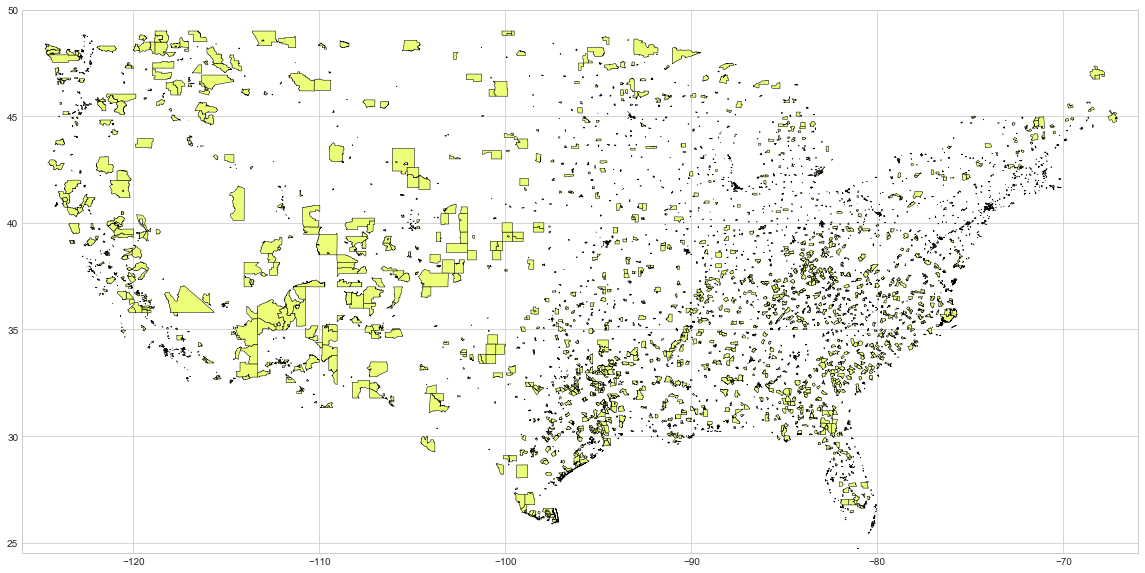

In [13]:
fig = pl.figure(figsize=(20,10))
ax = fig.add_subplot(111)

oz.plot(ax=ax, color='#EDFF78', edgecolor='k',linewidth=.5);
# Counties.plot(ax=ax, color='#EDFF78', edgecolor='k',linewidth=.2, alpha=0.6);
# Places.plot(ax=ax, color='r', edgecolor='k',linewidth=.8);
ax.set_xlim(-126,-66)
ax.set_ylim(24.5,50)
# ax.axis('off')

(40.5, 41)

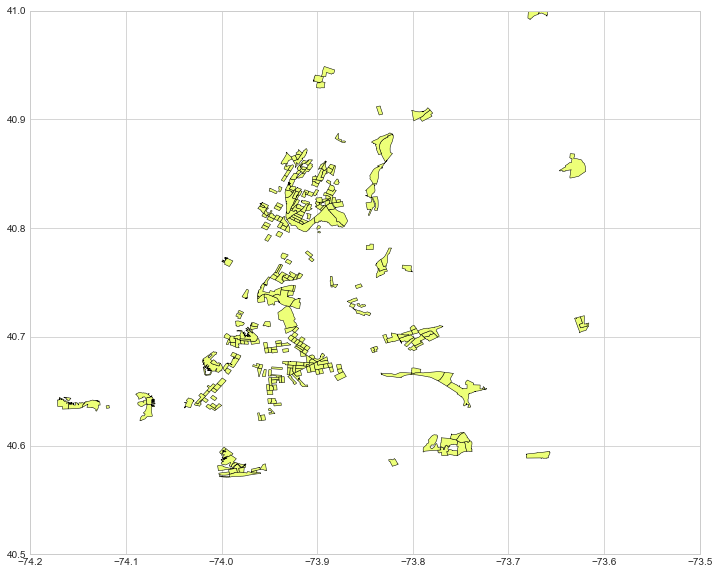

In [35]:
# New York State only, plotted to the boundaries of NYC
fig = pl.figure(figsize=(12,10))
ax = fig.add_subplot(111)

oz[oz['CLICKARROW'] == 'New York'].plot(ax=ax, color='#EDFF78', edgecolor='k',linewidth=.5);

ax.set_xlim(-74.2,-73.5)
ax.set_ylim(40.5,41)